In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.energy_consumption import Energy2011
from src.Constants import Constants
sns.set_theme(style="ticks")
import numpy as np

# 1. Energy consumption in buildings

In [4]:
constants = Constants()

In [10]:
trans = pd.read_csv('../data/privatna_vozila_2011.csv')
heat = pd.read_csv('../data/vinkovci_grijanje_2011.csv')
ele = pd.read_csv('../data/vinkovci_struja_2011.csv')

In [6]:
charts = Energy2011()

In [11]:
heat['potrošnja_energije(MWh)'] = heat['potrošnja_energije(kWh)'] / 1000

In [13]:
co2_factors = {
    "električna energija": Constants.co2_electricity_mwh_ton,
    "energy_diesel": Constants.co2_diesel_mwh_ton,
    "energy_petrol": Constants.co2_petrol_mwh_ton,
    "energy_lpg": Constants.co2_lpg_mwh_ton,
    "prirodni plin": Constants.co2_natgas_mwh_ton,
    "ogrjevno drvo": Constants.co2_wood_mwh_ton,
    "lož ulje": Constants.co2_heatoil_mwh_ton  # Corresponds to heat oil
}

In [29]:
seaborn_palette = sns.color_palette()

colors = {
    'lož ulje': seaborn_palette[1],  # This seems close to 'orange'
    'električna energija': seaborn_palette[0],  # This seems close to 'blue'
    'prirodni plin': seaborn_palette[3],  # This seems close to 'red'
    'ogrjevno drvo': seaborn_palette[2]  # This seems close to 'green'
}

In [14]:
heat['Emisije CO2 (t)'] = heat.apply(lambda row: row['potrošnja_energije(MWh)'] * co2_factors[row['energent']], axis=1)

In [17]:
tablica_1 = heat.pivot_table(
    index=['nadkategorija', 'kategorija', 'broj zgrada', 'ukupna_grijana_površina', 
           'specifična_potrošnja_energije(kWh/m2)'],
    columns='energent', 
    values='potrošnja_energije(MWh)',
    aggfunc='sum',
    fill_value=0
).groupby('kategorija').sum()

In [18]:
tablica_1_co2 = heat.pivot_table(
    index=['nadkategorija', 'kategorija', 'broj zgrada', 'ukupna_grijana_površina', 
           'specifična_potrošnja_energije(kWh/m2)'],
    columns='energent', 
    values='Emisije CO2 (t)',
    aggfunc='sum',
    fill_value=0
).groupby('kategorija').sum()

In [10]:
toplina_izvor = charts.heat_by_source()
toplina_sektor = charts.energy_by_sector('heat')
struja_sektor = charts.energy_by_sector('electricity')
gas_by_type = charts.gas_by_type()
gas_by_category = charts.gas_by_category()
illumination = charts.illumination()

/home/dionizije/Documents/vk_secap/src/energy_consumption.py:35: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby('energent').sum().reset_index()


KeyError: 'potrošnja_toplinske_energije(kWh)'

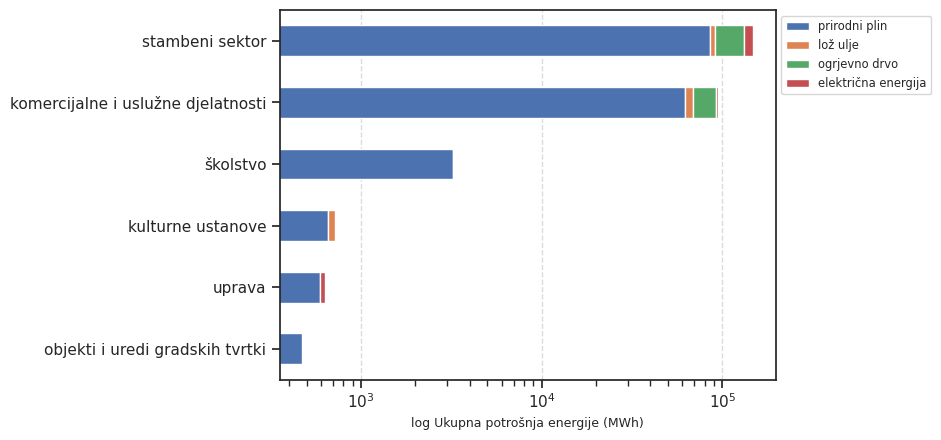

In [11]:
heat_pivot = heat.pivot(index='kategorija', columns='energent', values='potrošnja_energije(MWh)').fillna(0)
order = ['prirodni plin', 'lož ulje', 'ogrjevno drvo', 'električna energija']
heat_pivot = heat_pivot[order]
heat_pivot['Total'] = heat_pivot.sum(axis=1)
heat_pivot = heat_pivot.sort_values(by='Total', ascending=True).drop(columns=['Total'])


# Plot
fig, ax = plt.subplots()
heat_pivot.plot(kind='barh', stacked=True, ax=ax, width=0.5)
threshold = 50000  # adjust this threshold as needed
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Reduce font size for axis labels
plt.rc('axes', labelsize='x-small')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

# Set x-label and remove y-label
ax.set_xlabel("log Ukupna potrošnja energije (MWh)", fontsize=9)
ax.set_ylabel("")
ax.set_xscale('log')

# Adjust legend
legend = ax.legend(fontsize='x-small', loc='upper left', bbox_to_anchor=(1, 1))
plt.setp(legend.get_title(), fontsize='x-small')

# Layout adjustment for accommodating the legend outside the plot

plt.show()

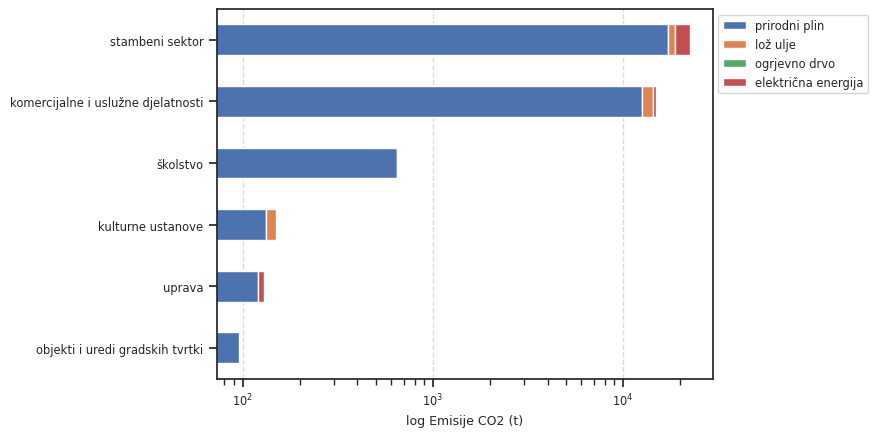

In [20]:
heat_co2_pivot = heat.pivot(index='kategorija', columns='energent', values='Emisije CO2 (t)').fillna(0)
order = ['prirodni plin', 'lož ulje', 'ogrjevno drvo', 'električna energija']
heat_co2_pivot = heat_co2_pivot[order]
heat_co2_pivot['Total'] = heat_co2_pivot.sum(axis=1)
heat_co2_pivot = heat_co2_pivot.sort_values(by='Total', ascending=True).drop(columns=['Total'])


# Plot
fig, ax = plt.subplots()
heat_co2_pivot.plot(kind='barh', stacked=True, ax=ax, width=0.5)
threshold = 50000  # adjust this threshold as needed
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Reduce font size for axis labels
plt.rc('axes', labelsize='x-small')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

# Set x-label and remove y-label
ax.set_xlabel("log Emisije CO2 (t)", fontsize=9)
ax.set_ylabel("")
ax.set_xscale('log')

# Adjust legend
legend = ax.legend(fontsize='x-small', loc='upper left', bbox_to_anchor=(1, 1))
plt.setp(legend.get_title(), fontsize='x-small')

# Layout adjustment for accommodating the legend outside the plot

plt.show()

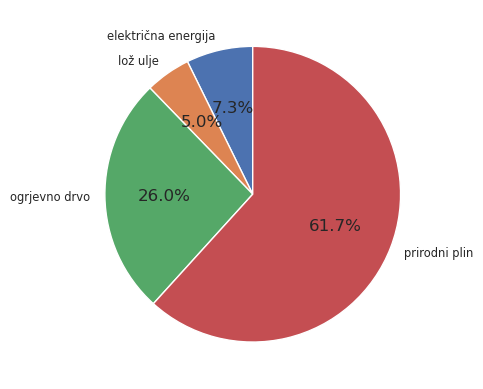

In [30]:
heat_pie_1 = heat.groupby('energent')['potrošnja_energije(MWh)'].sum()
ax = heat_pie_1.plot.pie(autopct='%1.1f%%', startangle=90, colors=[colors[energent] for energent in heat_pie_1.index])
ax.set_ylabel('')  # remove y-label
plt.show()

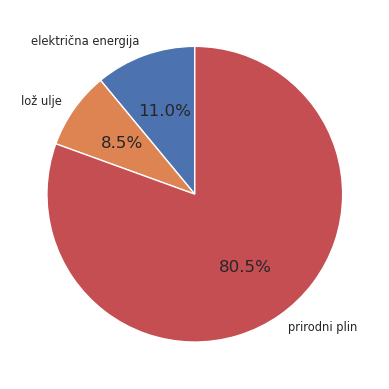

In [32]:
heat_co2_pie_1 = heat.groupby('energent')['Emisije CO2 (t)'].sum().drop('ogrjevno drvo')
ax = heat_co2_pie_1.plot.pie(autopct='%1.1f%%', startangle=90, colors=[colors[energent] for energent in heat_co2_pie_1.index])
ax.set_ylabel('')  # remove y-label
plt.show()

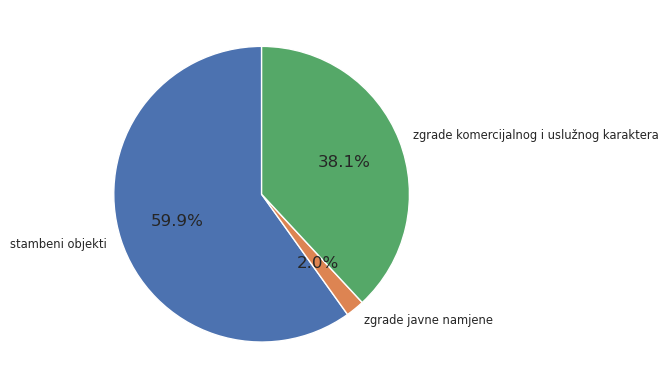

In [13]:
heat_pie_2 = heat.groupby('nadkategorija')['potrošnja_energije(MWh)'].sum()
ax = heat_pie_2.plot.pie(autopct='%1.1f%%', startangle=90)
ax.set_ylabel('')  # remove y-label
plt.show()

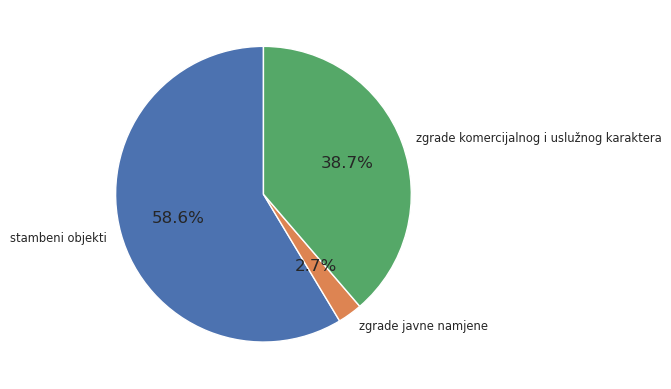

In [34]:
heat_co_pie_2 = heat.groupby('nadkategorija')['Emisije CO2 (t)'].sum()
ax = heat_pie_2.plot.pie(autopct='%1.1f%%', startangle=90)
ax.set_ylabel('')  # remove y-label
plt.show()

* CO2 heat

In [36]:
tablica_1_co2

energent,električna energija,lož ulje,ogrjevno drvo,prirodni plin
kategorija,,,,
komercijalne i uslužne djelatnosti,547.664832,1700.498448,0,12586.127233
kulturne ustanove,0.000000,16.700181,0,132.850867
objekti i uredi gradskih tvrtki,0.000000,0.000000,0,95.573668
stambeni sektor,3661.192080,1520.640927,0,17283.740411
uprava,8.845200,0.000000,0,119.947717
školstvo,0.000000,4.040367,0,650.327741


In [37]:
tablica_1_co2.sum()

energent
električna energija     4217.702112
lož ulje                3241.879922
ogrjevno drvo              0.000000
prirodni plin          30868.567637
dtype: float64

In [38]:
tablica_1_co2.sum().sum()

38328.149670700004

/tmp/ipykernel_403679/3969562995.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heat_co2_pivot['Total'] = heat_co2_pivot.sum(axis=1)


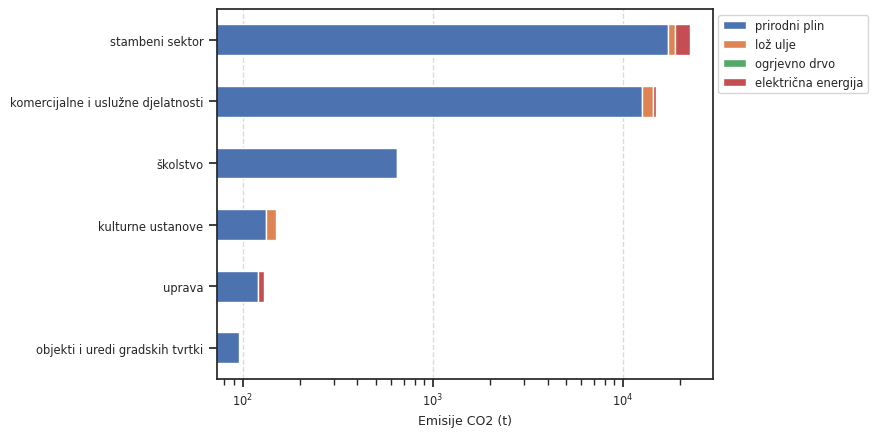

In [26]:
order = ['prirodni plin', 'lož ulje', 'ogrjevno drvo', 'električna energija']
heat_co2_pivot = tablica_1_co2[order]
heat_co2_pivot['Total'] = heat_co2_pivot.sum(axis=1)
heat_co2_pivot = heat_co2_pivot.sort_values(by='Total', ascending=True).drop(columns=['Total'])


# Plot
fig, ax = plt.subplots()
heat_co2_pivot.plot(kind='barh', stacked=True, ax=ax, width=0.5)
threshold = 50000  # adjust this threshold as needed
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Reduce font size for axis labels
plt.rc('axes', labelsize='x-small')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

# Set x-label and remove y-label
ax.set_xlabel("Emisije CO2 (t)", fontsize=9)
ax.set_ylabel("")
ax.set_xscale('log')

# Adjust legend
legend = ax.legend(fontsize='x-small', loc='upper left', bbox_to_anchor=(1, 1))
plt.setp(legend.get_title(), fontsize='x-small')

# Layout adjustment for accommodating the legend outside the plot

plt.show()

In [ ]:
ax = heat_pie_1.plot.pie(autopct='%1.1f%%', startangle=90)
ax.set_ylabel('')  # remove y-label
plt.show()

* Električna energija

In [14]:
ele['potrošnja_energije(MWh)'] = ele['potrošnja_energije(kWh)'] / 1000

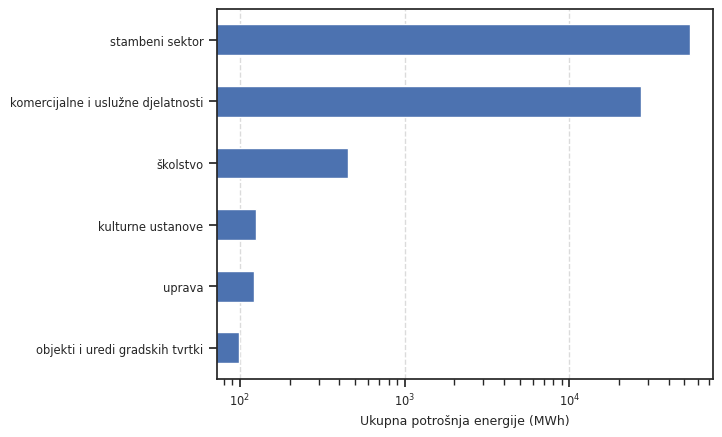

In [15]:
# Plot
fig, ax = plt.subplots()
ele_bar = ele.groupby('kategorija')['potrošnja_energije(MWh)'].sum()
ele_bar = ele_bar.sort_values(ascending=True).drop(columns=['Total'])
ele_bar.plot(kind='barh', stacked=True, ax=ax, width=0.5)
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Reduce font size for axis labels
plt.rc('axes', labelsize='x-small')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

# Set x-label and remove y-label
ax.set_xlabel("Ukupna potrošnja energije (MWh)", fontsize=9)
ax.set_ylabel("")
ax.set_xscale('log')

# Adjust legend

# Layout adjustment for accommodating the legend outside the plot

plt.show()

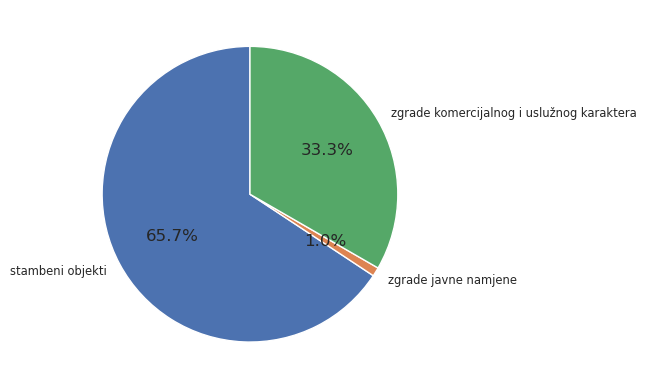

In [16]:
ele_pie_1 = ele.groupby('nadkategorija')['potrošnja_energije(MWh)'].sum()
ax = ele_pie_1.plot.pie(autopct='%1.1f%%', startangle=90)
ax.set_ylabel('')  # remove y-label
plt.show()

## Traffic

In [17]:
trans

,vrsta_prijevoza,broj,procijenjena_potrošena_masa_benzina(t),procijenjena_potrošena_masa_dizela(t),procijenjena_potrošena_masa_unp(t)
0,autobusni,6,NaN,13.9,NaN
1,taxi,1,NaN,1.6,NaN
2,osobna vozila,10005,2194.8,1047.0,44.9
3,teretna i radna vozila,2102,108.1,1557.0,NaN
4,mopedi i motocikli,910,53.0,NaN,NaN


In [18]:
trans['energy_diesel'] = trans['procijenjena_potrošena_masa_dizela(t)'] * constants.diesel_ton_mwh
trans['energy_petrol'] = trans['procijenjena_potrošena_masa_benzina(t)'] * constants.petrol_ton_mwh
trans['energy_lpg'] = trans['procijenjena_potrošena_masa_unp(t)'] * constants.lpg_ton_mwh
trans = trans.fillna(0)

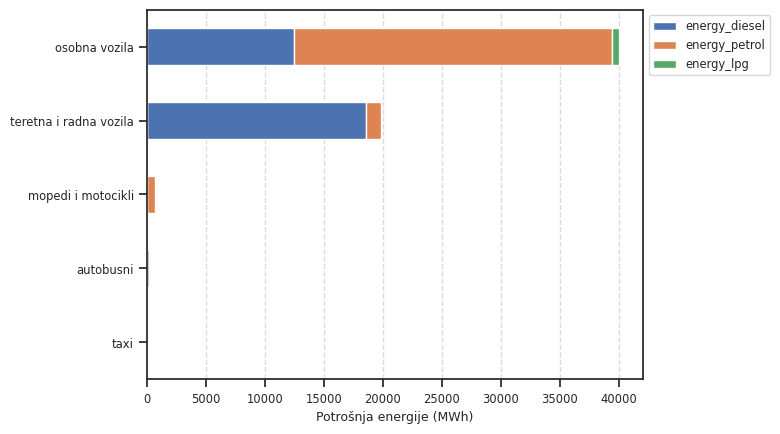

In [19]:
#df_pivot = trans.pivot(index='vrsta_prijevoza', columns=['energy_diesel', 'energy_petrol', 'energy_lpg']).fillna(0)
order = ['energy_diesel', 'energy_petrol', 'energy_lpg']
trans_pivot = trans.set_index('vrsta_prijevoza')
trans_pivot = trans_pivot[order]
trans_pivot['Total'] = trans_pivot.sum(axis=1)
trans_pivot = trans_pivot.sort_values(by='Total', ascending=True).drop(columns=['Total'])


# Plot
fig, ax = plt.subplots()
trans_pivot.plot(kind='barh', stacked=True, ax=ax, width=0.5)
threshold = 50000  # adjust this threshold as needed
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Reduce font size for axis labels
plt.rc('axes', labelsize='x-small')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

# Set x-label and remove y-label
ax.set_xlabel("Potrošnja energije (MWh)", fontsize=9)
ax.set_ylabel("")

# Adjust legend
legend = ax.legend(fontsize='x-small', loc='upper left', bbox_to_anchor=(1, 1))
plt.setp(legend.get_title(), fontsize='x-small')

# Layout adjustment for accommodating the legend outside the plot

plt.show()

In [20]:
trans_pie_1 = trans_pivot.sum(axis=1)

In [21]:
trans_pie_1['Taxi, autobusni, mopedi i motocikli'] = trans_pie_1['taxi'] + trans_pie_1['autobusni'] + trans_pie_1['mopedi i motocikli']

In [22]:
trans_pie_1 = trans_pie_1.drop(['taxi', 'autobusni', 'mopedi i motocikli'])

<Axes: >

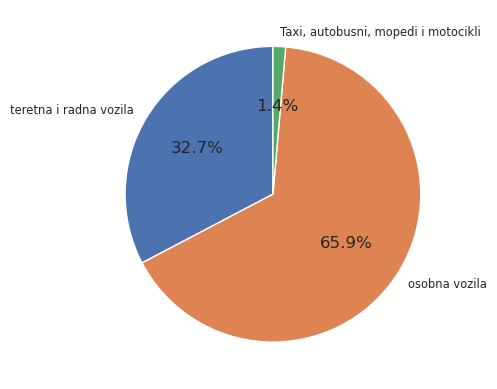

In [23]:
trans_pie_1.plot.pie(autopct='%1.1f%%', startangle=90)

In [24]:
trans_melted = trans_pivot.reset_index().melt(id_vars=['vrsta_prijevoza'], 
                                  value_vars=['energy_diesel', 'energy_petrol', 'energy_lpg'],
                                  var_name='energy_source', 
                                  value_name='amount')

Text(0, 0.5, '')

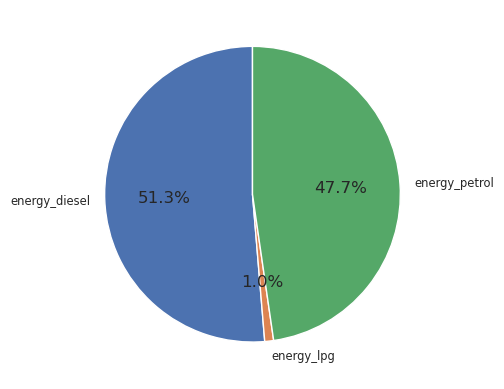

In [25]:
trans_pie_2 = trans_melted.groupby('energy_source')['amount'].sum()
ax = trans_pie_2.plot.pie(autopct='%1.1f%%', startangle=90)
ax.set_ylabel('')

In [26]:
ele['energent'] = 'električna energija'

In [27]:
trans = pd.DataFrame(trans_pie_2).reset_index().rename(columns={'energy_source': 'energent', 'amount': 'potrošnja_energije(MWh)'})

In [28]:
trans['nadkategorija'] = 'promet'

In [29]:
heat = heat[['energent', 'potrošnja_energije(MWh)', 'kategorija', 'nadkategorija']]
ele = ele[['energent', 'potrošnja_energije(MWh)', 'kategorija', 'nadkategorija']]

In [59]:
total = pd.concat([ele, trans, heat]).groupby(['nadkategorija', 'energent'])['potrošnja_energije(MWh)'].sum()

In [60]:
total = total.reset_index()
total['nadkategorija'] = total['nadkategorija'].replace({
    'stambeni objekti': 'zgradarstvo',
    'zgrade javne namjene': 'zgradarstvo',
    'zgrade komercijalnog i uslužnog karaktera': 'zgradarstvo'
})
rasvjeta_data = ['javna rasvjeta', 'električna energija', 2922.5]
total = pd.concat([total, pd.DataFrame([rasvjeta_data], columns=total.columns)], ignore_index=True)
# Group by and sum
total = total.groupby(['nadkategorija', 'energent'])['potrošnja_energije(MWh)'].sum()

In [69]:
total

nadkategorija   energent           
javna rasvjeta  električna energija      2922.50000
promet          energy_diesel           31172.05000
                energy_lpg                588.19000
                energy_petrol           28977.57000
zgradarstvo     električna energija    100230.28500
                lož ulje                12279.84819
                ogrjevno drvo           64439.42373
                prirodni plin          152814.69127
Name: potrošnja_energije(MWh), dtype: float64

[None, None]

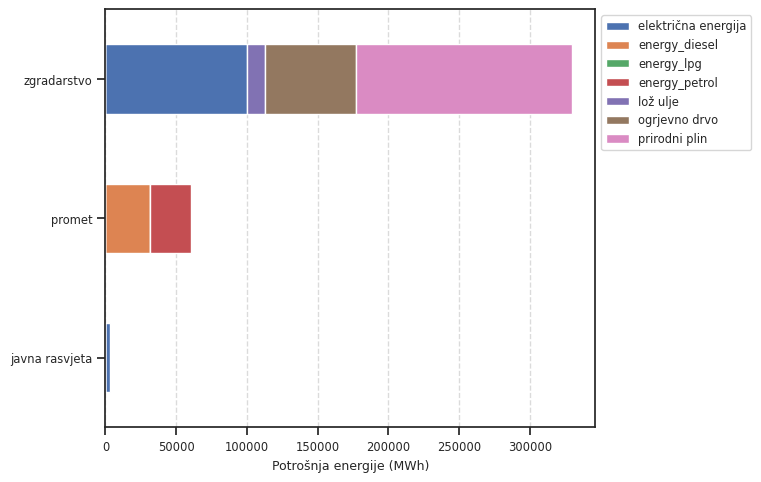

In [79]:
total_bar = pd.Series(total, index=total.index, name="potrošnja_energije(MWh)")

# Unstack the Series to get a DataFrame
order = ['električna energija', 'energy_diesel', 'energy_lpg', 'energy_petrol', 'lož ulje', 'ogrjevno drvo', 'prirodni plin']
total_bar = total_bar.unstack()
total_bar = total_bar[order]

# Plotting
fig, ax = plt.subplots()
ax = total_bar.plot(kind='barh', ax=ax, stacked=True, width=0.5)
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Reduce font size for axis labels
plt.rc('axes', labelsize='x-small')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
plt.tight_layout()
ax.set_xlabel("Potrošnja energije (MWh)", fontsize=9)
ax.set_ylabel("")

# Adjust legend
legend = ax.legend(fontsize='x-small', loc='upper left', bbox_to_anchor=(1, 1))
plt.setp(legend.get_title(), fontsize='x-small')

In [82]:
total

nadkategorija   energent           
javna rasvjeta  električna energija      2922.50000
promet          energy_diesel           31172.05000
                energy_lpg                588.19000
                energy_petrol           28977.57000
zgradarstvo     električna energija    100230.28500
                lož ulje                12279.84819
                ogrjevno drvo           64439.42373
                prirodni plin          152814.69127
Name: potrošnja_energije(MWh), dtype: float64

In [90]:
total_source = total.groupby('energent').sum().sort_values()

Text(-47.125, 0.5, '')

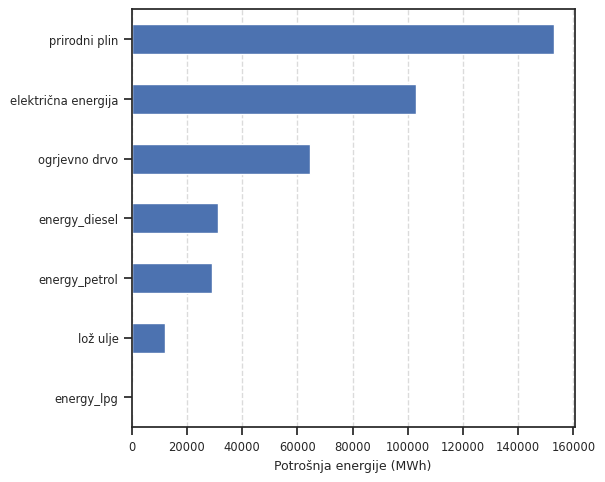

In [91]:
fig, ax = plt.subplots()
ax = total_source.plot(kind='barh', ax=ax, stacked=True, width=0.5)
ax.grid(axis='x', linestyle='--', alpha=0.7)
plt.rc('axes', labelsize='x-small')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
plt.tight_layout()
ax.set_xlabel("Potrošnja energije (MWh)", fontsize=9)
ax.set_ylabel("")

Text(0, 0.5, '')

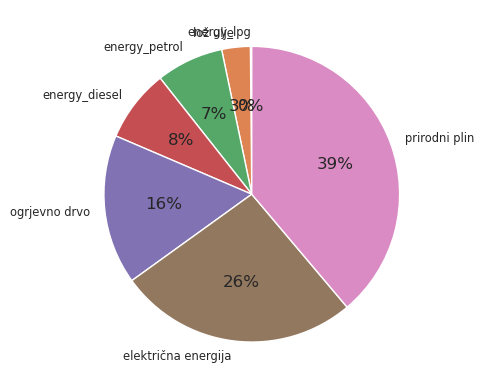

In [99]:
ax = total_source.plot.pie(autopct='%1.0f%%', startangle=90)
ax.set_ylabel('')